<a href="https://colab.research.google.com/github/Margaret-107/calligraphy/blob/main/Copy_of_CV_Assignment_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2022**

Due date: **September 29th 2022, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2022/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95% 

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard. 

# Dataset Preparation
___

1.  Download `dataset.zip` from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`. 
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it. 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [18]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cv_kaggle_assignment/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cv_kaggle_assignment


# Dataloader

In [19]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

batch_size = 256
momentum = 0.9
lr = 0.01
epochs = 30
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

### input = 29?
class Net_ori(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, padding = 1,kernel_size=3)
        self.conv11 = nn.Conv2d(32,32,padding=1, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1_drop = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(32, 64,padding =1, kernel_size=3)
        self.conv21 = nn.Conv2d(64, 64,padding =1, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(64, 128, padding = 1, kernel_size=3)
        self.conv31 = nn.Conv2d(128,128,padding = 1, kernel_size = 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, nclasses)

    def forward(self, x):
        #x = self.stn(x)
        x = self.conv1_drop(self.bn1(F.relu(self.conv11(F.relu(self.conv1(x)))))) #16
        x = F.max_pool2d(self.conv2_drop(self. bn2(F.relu(self.conv21(F.relu(self.conv2(x)))))), 2) #8
        x = F.max_pool2d(self.conv3_drop(self.bn3(F.relu(self.conv31(F.relu(self.conv3(x)))))), 2) #4
        x = x.view(-1,128*8*8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Training

In [27]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

x_points = []
y_points = []

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if epoch > 10:
          lr = lr/2
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    y_points.append(correct / len(val_loader.dataset))



for epoch in range(1, epochs + 1):
    x_points.append(epoch)
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.956172
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.266682

Validation set: Average loss: 0.3806, Accuracy: 3416/3870 (88%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.124729
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.094975

Validation set: Average loss: 0.1876, Accuracy: 3637/3870 (94%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.038625
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.014115

Validation set: Average loss: 0.1713, Accuracy: 3690/3870 (95%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.016754
Train Epoch: 4 [25600/35339 (72%)]	Loss: 0.012474

Validation set: Average loss: 0.1405, Accuracy: 3724/3870 (96%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.008310
Train Epoch: 5 [25600/35339 (72%)]	Loss: 0.004790

Validation set: Average loss: 0.1171, Accuracy: 3738/3870 (97%)


Saved model to model_5.pth.
Train Epoch: 6 [0/35339 (0%)]	Loss: 0.012876
Train

# Ploting

Text(0, 0.5, 'accuracy')

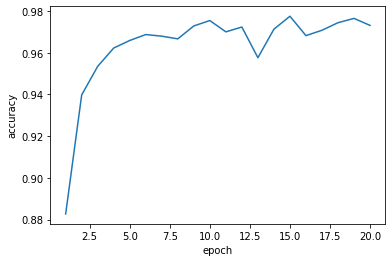

In [28]:
import numpy as np
import matplotlib.pyplot as plt

x_points = np.array(x_points)
y_points = np.array(y_points)
plt.plot(x_points,y_points)
plt.xlabel("epoch")
plt.ylabel("accuracy")

# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.